<hr style="border-width:4px; border-color:coral"/>

# Creating fractals (continued)
<hr style="border-width:4px; border-color:coral"/>

Fractals are fascinating images that can be computed using a very simple fixed-point type iteration.  And because the iterations run independently, algorithms for fractal generation parallelize very naturally.  The code below illustrate the Julia fractal.  You can read more about Julia fractals on this <a href="https://en.wikipedia.org/wiki/Julia_set">Wikipedia page</a>.

In [1]:
%matplotlib inline
import multiprocessing as mp
mp.set_start_method('fork')
from matplotlib.pyplot import *
from numpy import *

In [2]:
import warnings
warnings.simplefilter("ignore")   # Suppress overflow run time warnings

def julia_set(ax,bx,ay,by, Nx, Ny, kmax,c):
    
    # Generate points in complex planes D
    xe = linspace(ax,bx, Nx+1)
    ye = linspace(ay,by, Ny+1)
    dx = (bx-ax)/Nx
    dy = (by-ay)/Ny
    xc = xe[:-1] + dx/2            
    yc = ye[:-1] + dy/2            

    # Set of initial values Z0 : zk is a Nx x Ny matrix
    zk = xc + yc[:, None] * 1j
    
    # Constant needed for Julia fractal : g(z) = z^2 + c
    C = zeros_like(zk) + c
    
    # Divergence criteria
    rho = 2.0
    
    # Vectorize the computation of g(z); Use 
    escape_time = zeros_like(zk,dtype=int) + kmax
    for n in range(kmax):
        escaped = less(escape_time,kmax)
        if all(escaped):
            break
        I = logical_and(greater(abs(zk), rho),logical_not(escaped))
        escape_time[I] = n
        notI = not_equal(I,True)
        zk[notI] = zk[notI]**2 + C[notI]
    Iz = equal(escape_time,kmax)
    nz = count_nonzero(Iz)  # Number of zero values who never escaped
    return escape_time,nz

In [3]:
res = 1024
kmax = 1000

domain_width = 4
xc = 0
yc = 0

ax0, bx0 = xc - domain_width/2, xc + domain_width/2
ay0, by0 = yc - domain_width/2, yc + domain_width/2

# Choice from Mandelbrot set
c = -0.8+0.156*1j

In [4]:
%%time

# Create full fractal

N0 = res

M, nz = julia_set(ax0, bx0, ay0, by0, N0, N0, kmax,c)
print(f"Number of values that did not escape {nz}")

Number of values that did not escape 176
CPU times: user 21.8 s, sys: 2.64 s, total: 24.4 s
Wall time: 24.4 s


CPU times: user 133 ms, sys: 18.2 ms, total: 152 ms
Wall time: 150 ms


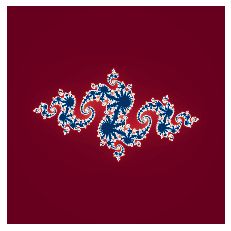

In [5]:
%%time

dpi = 16         # Figure might not show up in the notebook if dpi is too high;  but PNG file will be created (below).

# Show image in notebook
imshow(M,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
gca().axis('off')

# Save image to PNG file. Use 'imsave' so we won't get any border or padding
imsave("fractal_01.png",M,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')


<hr style="border-width:4px; border-color:coral"/>

# Parallel implementation

<hr style="border-width:4px; border-color:coral"/>



In [6]:


nquads = 4

dex = linspace(ax0,bx0,nquads+1)
dey = linspace(ay0,by0,nquads+1)

N = res//nquads
assert N*nquads == res, 'res must be divisible by nquads'

nprocs = 4

In [7]:
%%time 

def create_square(queue):
    quad_num,ax,bx,ay,by,N,kmax,c = queue.get()    
    M,nz = julia_set(ax, bx, ay, by, N, N, kmax,c)    
    nz_total.value += nz
    
    N2 = N**2 
    f_shared[quad_num*N2:(quad_num+1)*N2] = M.ravel() #know which quad you are at, k is the quad num


nz_total = mp.Value('i',0)
F=empty((res,res),dtype=int) #large array we will plot e.g 2048
f_shared=mp.Array('i',F.ravel())
#F_array = mp.Array('i',F)

data = []
k=0
queue = mp.Queue()
for i in range(nquads):
    for j in range(nquads):
        ax,bx = dex[i],dex[i+1]
        ay,by = dey[j],dey[j+1]
        queue.put((k,ax,bx,ay,by,N,kmax,c))
        k+=1
        
njobs = nquads**2
jobs = []
for i in range(njobs):        
    p = mp.Process(target=create_square,args=(queue,))
    jobs.append(p)
    
for p in jobs:
    p.start()
    
for p in jobs:
    p.join()
    
nzt = nz_total.value

print(f"Number of values that did not escape {nzt}")    
print("All Done")    

Number of values that did not escape 176
All Done
CPU times: user 230 ms, sys: 94.6 ms, total: 325 ms
Wall time: 5.48 s


In [8]:
%%time 
k=0
N2=N**2
for i in range(nquads):
    for j in range(nquads):
        F[j*N:(j+1)*N,i*N:(i+1)*N] = array(f_shared[k*N2:(k+1)*N2]).reshape((N,N))
        k+=1

CPU times: user 103 ms, sys: 5.55 ms, total: 109 ms
Wall time: 106 ms


CPU times: user 133 ms, sys: 20.2 ms, total: 153 ms
Wall time: 152 ms


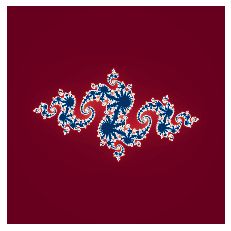

In [9]:
%%time

dpi = 16         # Figure might not show up in the notebook if dpi is too high;  but PNG file will be created (below).

# Show image in notebook
imshow(F,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
gca().axis('off')

# Save image to PNG file. Use 'imsave' so we won't get any border or padding
imsave("fractal_02.png",F,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')


# Using a Pool

In [24]:
%%time 

def create_square(args):
    ax,bx,ay,by,N,kmax,c = args
    M,nz = julia_set(ax, bx, ay, by, N, N, kmax,c)    
    return M,nz

data = []
for i in range(nquads):
    for j in range(nquads):
        ax,bx = dex[i],dex[i+1]
        ay,by = dey[j],dey[j+1]
        data.append((ax,bx,ay,by,N,kmax,c))
        
pool=mp.Pool(processes=4)

with mp.Pool(processes=4) as pool:
    results_async=pool.map_async(create_square,data) #_asyn means the result from each process will be returned once its done
    pool.close()
    pool.join()

results=results_async.get()
print("All Done")    

All Done
CPU times: user 33.9 ms, sys: 57.9 ms, total: 91.8 ms
Wall time: 3.3 s


In [25]:
%%time 

F=empty((res,res),dtype=int)
for i in range(nquads):
    for j in range(nquads):
        M,nz=results.pop(0)
        F[j*N:(j+1)*N,i*N:(i+1)*N] = M
        nzt+=nz
print(f"Number of values that did not escape {nzt}")  

Number of values that did not escape 528
CPU times: user 4.48 ms, sys: 7.46 ms, total: 11.9 ms
Wall time: 9.83 ms


CPU times: user 116 ms, sys: 16.9 ms, total: 133 ms
Wall time: 131 ms


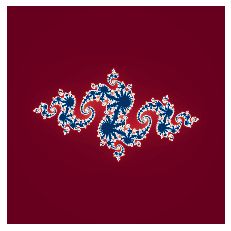

In [23]:
%%time

dpi = 16         # Figure might not show up in the notebook if dpi is too high;  but PNG file will be created (below).

# Show image in notebook
imshow(F,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
gca().axis('off')

# Save image to PNG file. Use 'imsave' so we won't get any border or padding
imsave("fractal_03.png",F,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')
